In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
sns.set_theme()

In [2]:
BATCH_SIZE = 64
EPOCHS = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])),
  batch_size=BATCH_SIZE, shuffle=True)

val_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])),
  batch_size=BATCH_SIZE, shuffle=False)

In [4]:
batch, batch_labels = next(iter(val_loader))
batch.shape

torch.Size([64, 1, 28, 28])

In [5]:
def print_digits(imgs, real_imgs, epoch):
    fig, axes = plt.subplots(2, 8, figsize=(18,6))
    for i in range(8):
        axes[0,i].imshow(imgs[i].reshape(28, 28), cmap='gray')
        axes[0,i].grid(False)
        axes[0,i].set_title(f"Epoch: {epoch}, Encoded")
    for i in range(8):
        axes[1,i].imshow(real_imgs[i].reshape(28, 28), cmap='gray')
        axes[1,i].grid(False)
        axes[1,i].set_title(f"Epoch: {epoch}, Real")

In [6]:
class Autoencoder_linear(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.decoder(self.encoder(x))
    
    def fit(self, train_loader, val_loader):
        self.train_loader = train_loader
        self.val_loader = val_loader
        
    def _train(self, epochs=10, criterion=None, optimizer=None):
        self.epochs = epochs
        self.criterion = criterion
        self.optimizer = optimizer
        self.loss = []
        self.val_loss = []
        self.outputs = []
        
        for i in range(self.epochs):
            pred_val = None
            for (X_train, _) in self.train_loader:
                X_train = X_train.reshape(-1, 28*28).to(device)
                pred = self(X_train)
                loss = self.criterion(pred, X_train)
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
            self.eval()
            
            with torch.no_grad():
                for j, (X_val, _) in enumerate(self.val_loader):
                    X_val = X_val.reshape(-1, 28*28).to(device)
                    pred_ = self(X_val)
                    
                    if j == 0:
                        pred_val = pred_
                    
                    val_loss = self.criterion(pred_, X_val)
                    
            self.loss.append(loss.cpu().item())
            self.val_loss.append(val_loss.cpu().item())
                
            print(f"Epoch: {i+1}, Loss: {loss.cpu().item()}, Val loss: {val_loss.cpu().item()}")
            self.outputs.append(pred_val.cpu())
            
            self.train()
            
    def plot_loss(self):
        plt.figure(figsize=(18,8))
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        sns.lineplot(x=range(1, self.epochs+1), y=self.loss, label='loss')
        sns.lineplot(x=range(1, self.epochs+1), y=self.val_loss, label='val_loss')
        
    def plot_outputs(self):
        for i, output in enumerate(self.outputs):
            print_digits(output, batch, i+1)

In [7]:
model_linear = Autoencoder_linear().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_linear.parameters(), lr=1e-3)
model_linear.fit(train_loader, val_loader)
model_linear._train(epochs=EPOCHS, criterion=criterion, optimizer=optimizer)

Epoch: 1, Loss: 0.048832353204488754, Val loss: 0.05232230946421623
Epoch: 2, Loss: 0.04120653495192528, Val loss: 0.04195472598075867
Epoch: 3, Loss: 0.04006806015968323, Val loss: 0.038809988647699356
Epoch: 4, Loss: 0.03530101105570793, Val loss: 0.03804786130785942
Epoch: 5, Loss: 0.03962307050824165, Val loss: 0.036017559468746185
Epoch: 6, Loss: 0.03692308068275452, Val loss: 0.03700420260429382
Epoch: 7, Loss: 0.03847559913992882, Val loss: 0.03426066040992737
Epoch: 8, Loss: 0.038362015038728714, Val loss: 0.03439546748995781
Epoch: 9, Loss: 0.030919920653104782, Val loss: 0.03488031029701233
Epoch: 10, Loss: 0.035602398216724396, Val loss: 0.033975936472415924


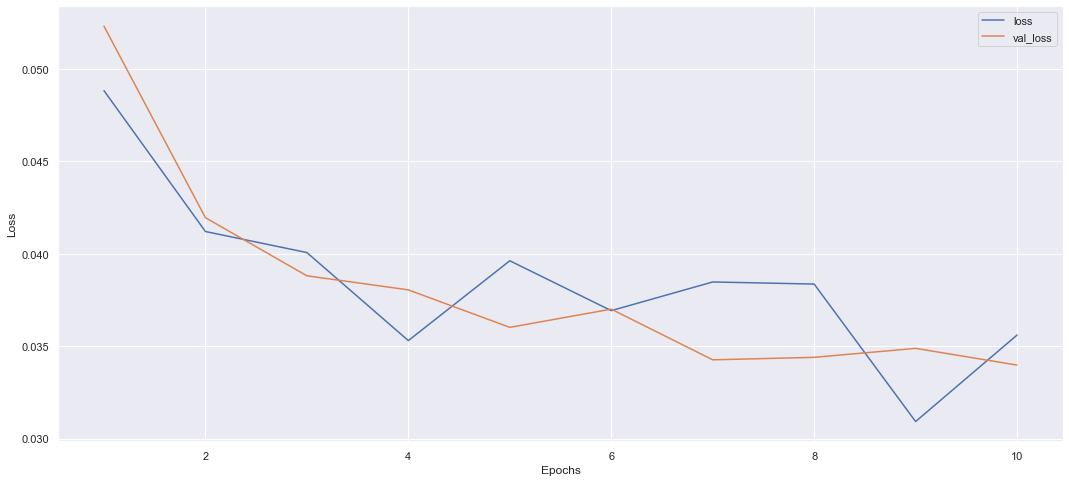

In [8]:
model_linear.plot_loss()

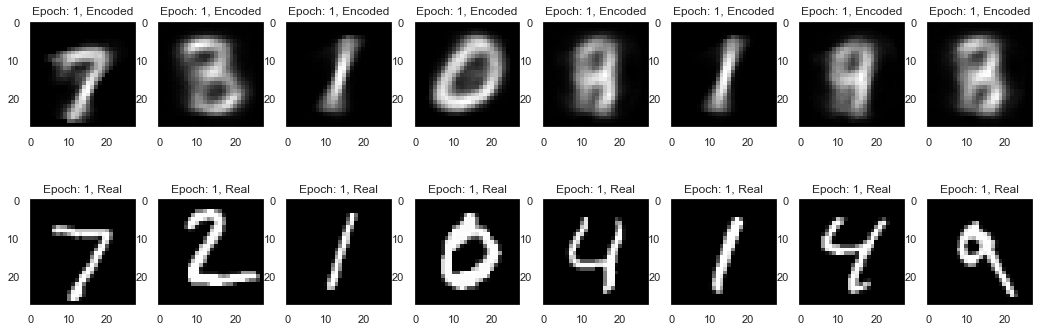

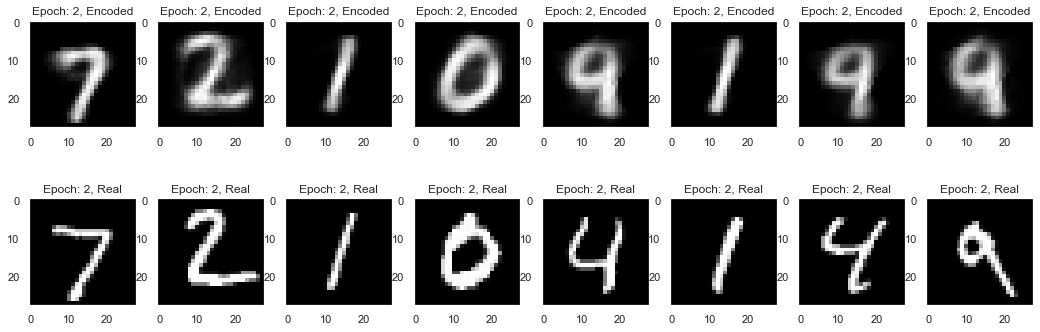

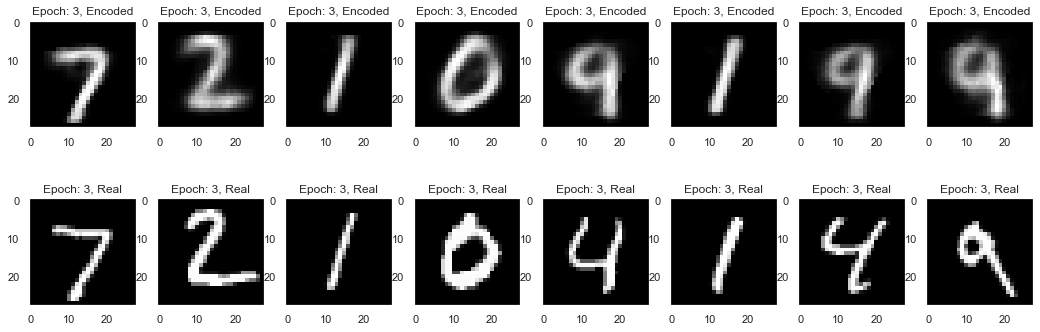

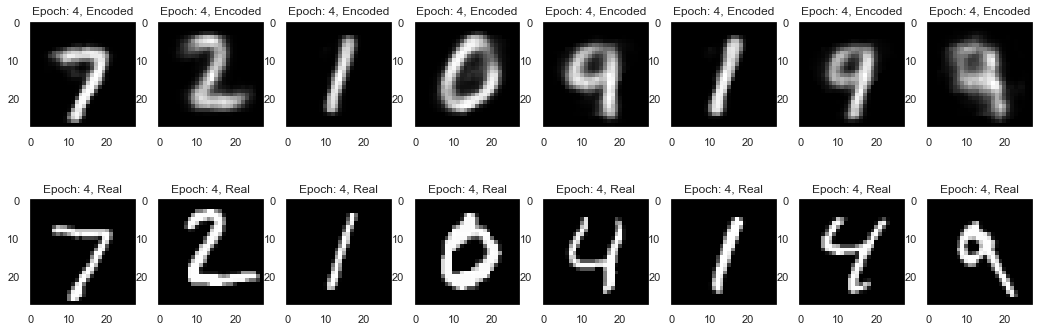

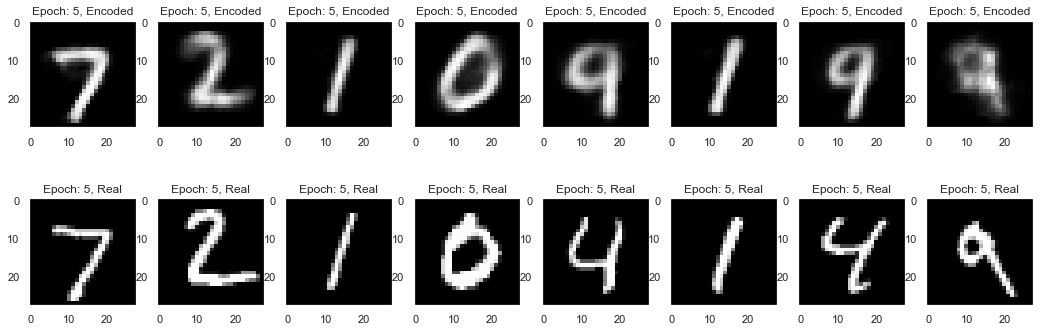

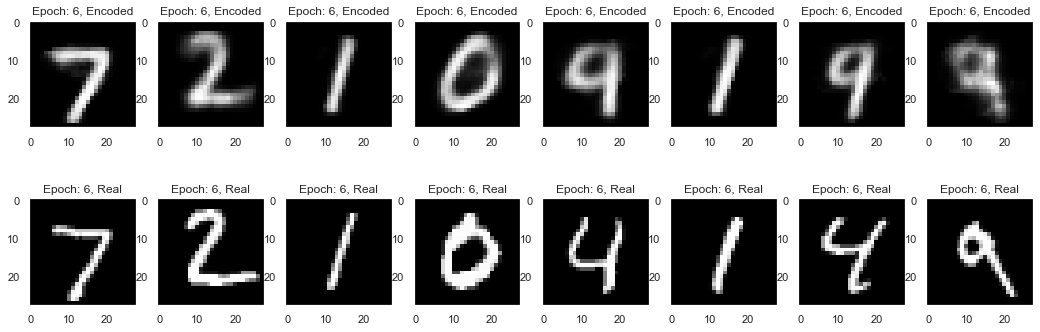

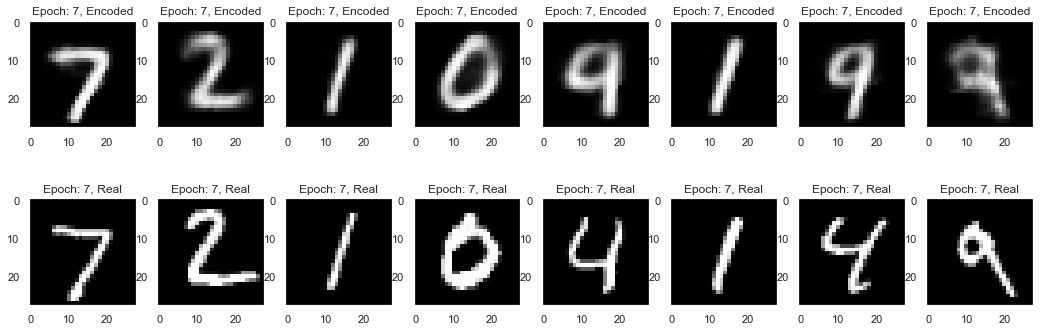

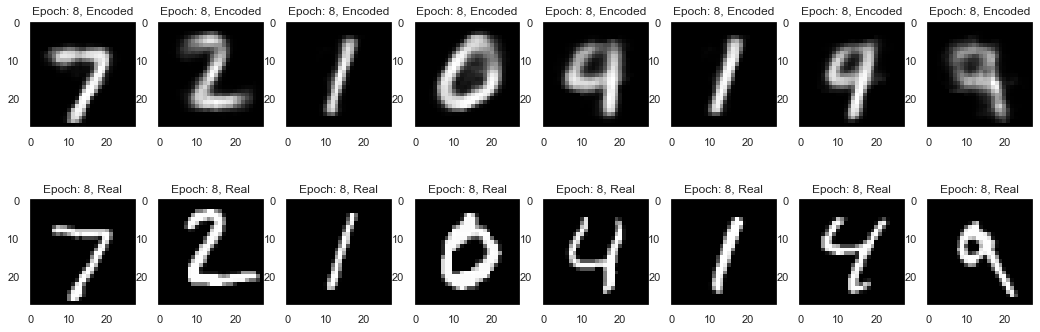

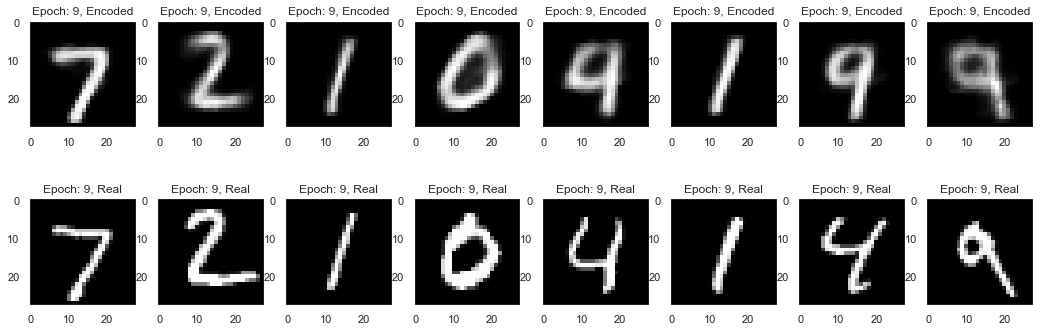

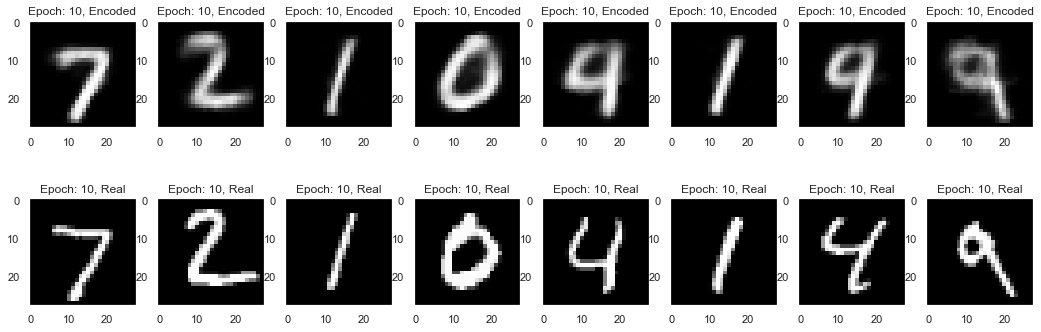

In [9]:
model_linear.plot_outputs()

In [10]:
class Autoencoder_conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3,3), stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=(3,3), stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.decoder(self.encoder(x))
    
    def fit(self, train_loader, val_loader):
        self.train_loader = train_loader
        self.val_loader = val_loader
        
    def _train(self, epochs=10, criterion=None, optimizer=None):
        self.epochs = epochs
        self.criterion = criterion
        self.optimizer = optimizer
        self.loss = []
        self.val_loss = []
        self.outputs = []
        
        for i in range(self.epochs):
            pred_val = None
            for (X_train, _) in self.train_loader:
                X_train = X_train.to(device)
                pred = self(X_train)
                loss = self.criterion(pred, X_train)
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
            self.eval()
            
            with torch.no_grad():
                for j, (X_val, _) in enumerate(self.val_loader):
                    X_val = X_val.to(device)
                    pred_ = self(X_val)
                    
                    if j == 0:
                        pred_val = pred_
                    
                    val_loss = self.criterion(pred_, X_val)
                    
            self.loss.append(loss.cpu().item())
            self.val_loss.append(val_loss.cpu().item())
                
            print(f"Epoch: {i+1}, Loss: {loss.cpu().item()}, Val loss: {val_loss.cpu().item()}")
            self.outputs.append(pred_val.cpu())
            
            self.train()
            
    def plot_loss(self):
        plt.figure(figsize=(18,8))
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        sns.lineplot(x=range(1, self.epochs+1), y=self.loss, label='loss')
        sns.lineplot(x=range(1, self.epochs+1), y=self.val_loss, label='val_loss')
        
    def plot_outputs(self):
        for i, output in enumerate(self.outputs):
            print_digits(output, batch, i+1)

In [11]:
model_cnn = Autoencoder_conv().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=1e-3)
model_cnn.fit(train_loader, val_loader)
model_cnn._train(epochs=EPOCHS, criterion=criterion, optimizer=optimizer)

Epoch: 1, Loss: 0.007166744209825993, Val loss: 0.005986659787595272
Epoch: 2, Loss: 0.005000380799174309, Val loss: 0.0035128206945955753
Epoch: 3, Loss: 0.003629883751273155, Val loss: 0.002870786003768444
Epoch: 4, Loss: 0.003013269044458866, Val loss: 0.0023677211720496416
Epoch: 5, Loss: 0.0031352948863059282, Val loss: 0.0022594539914280176
Epoch: 6, Loss: 0.0023294200655072927, Val loss: 0.0021425012964755297
Epoch: 7, Loss: 0.0022627331782132387, Val loss: 0.001965235685929656
Epoch: 8, Loss: 0.0021011321805417538, Val loss: 0.0019646843429654837
Epoch: 9, Loss: 0.0020832924637943506, Val loss: 0.0019487706013023853
Epoch: 10, Loss: 0.0022322300355881453, Val loss: 0.001821259967982769


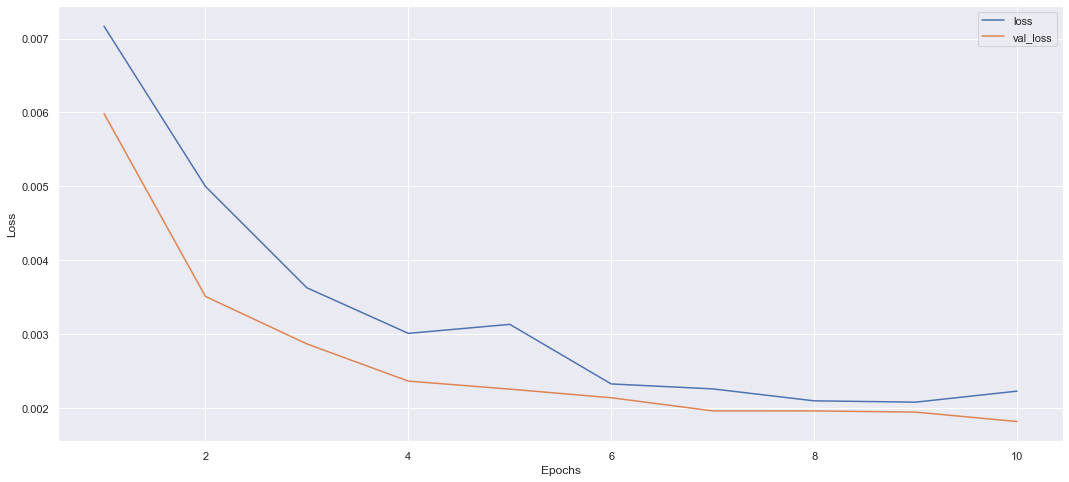

In [12]:
model_cnn.plot_loss()

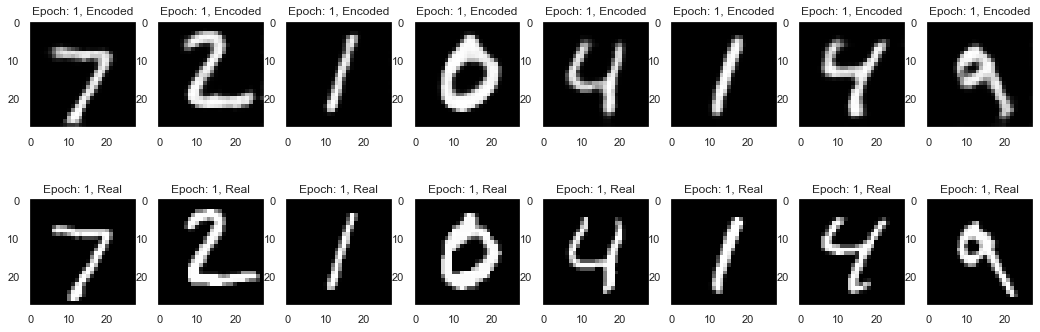

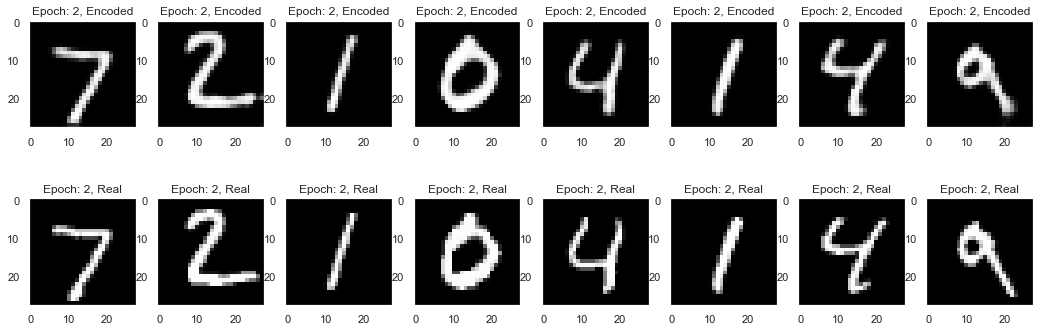

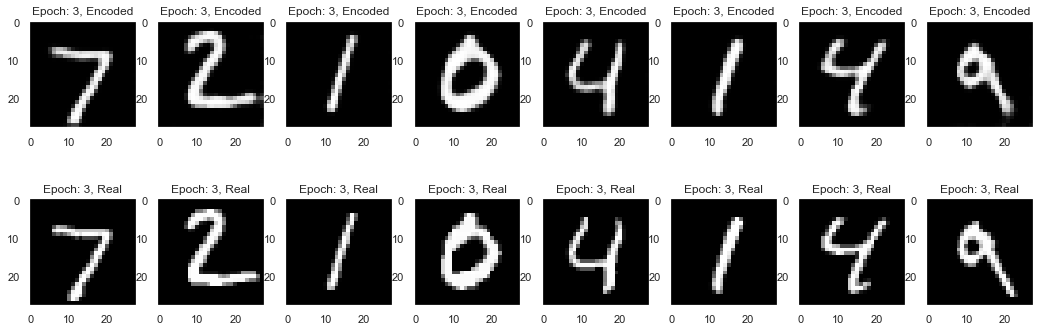

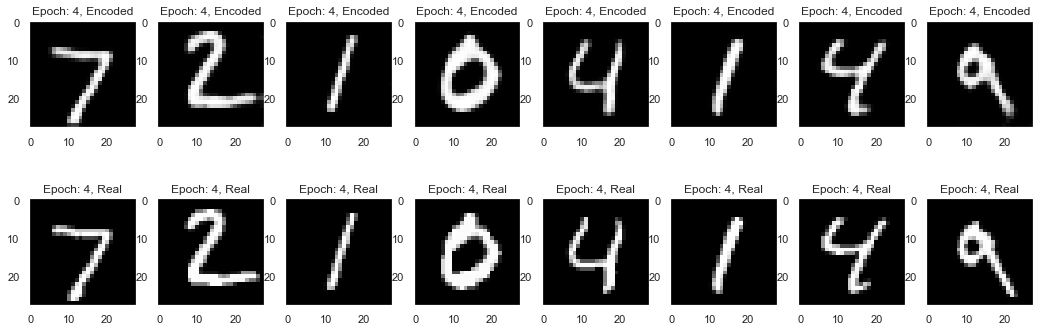

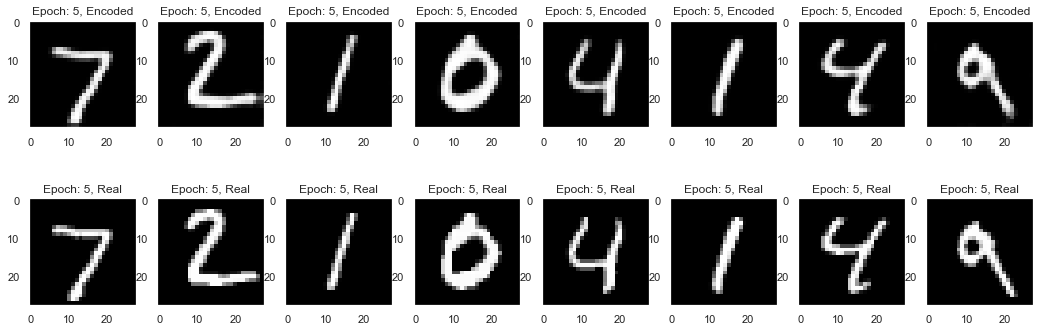

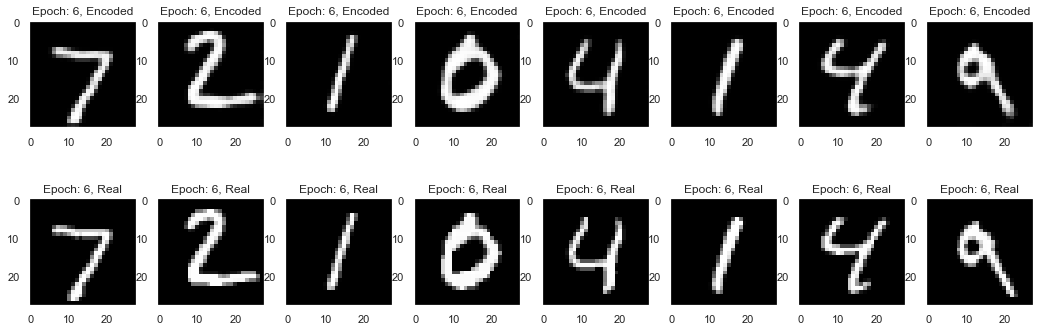

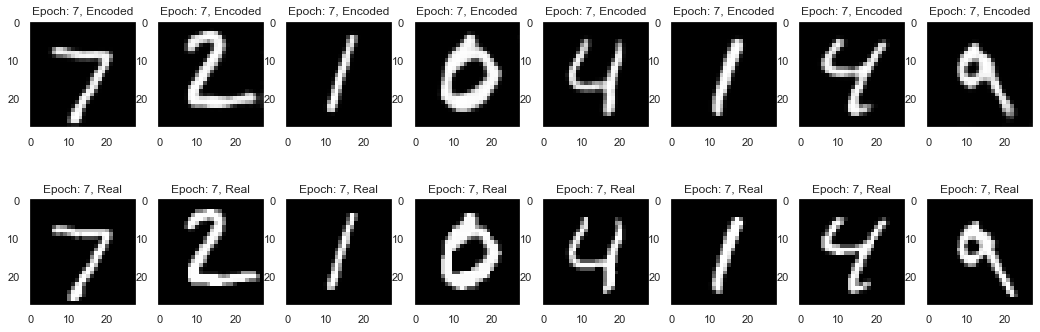

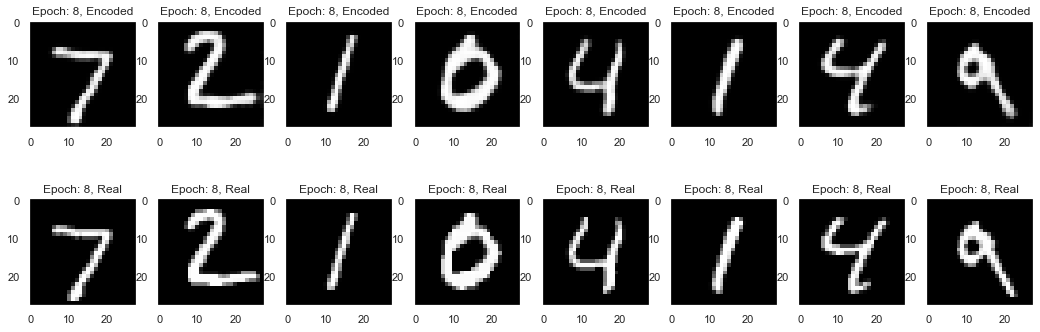

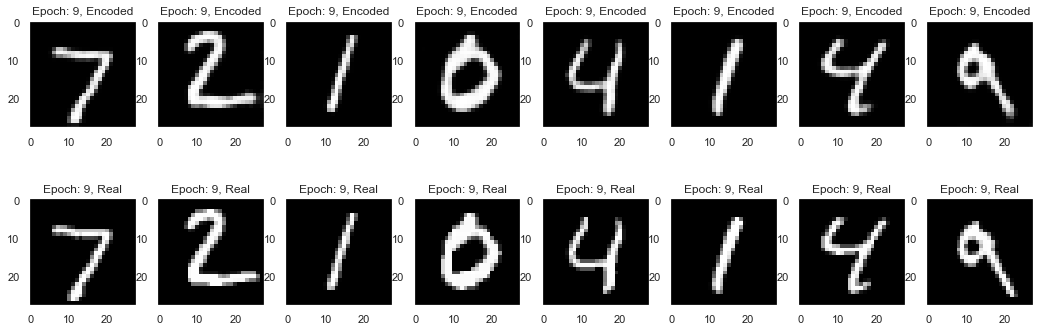

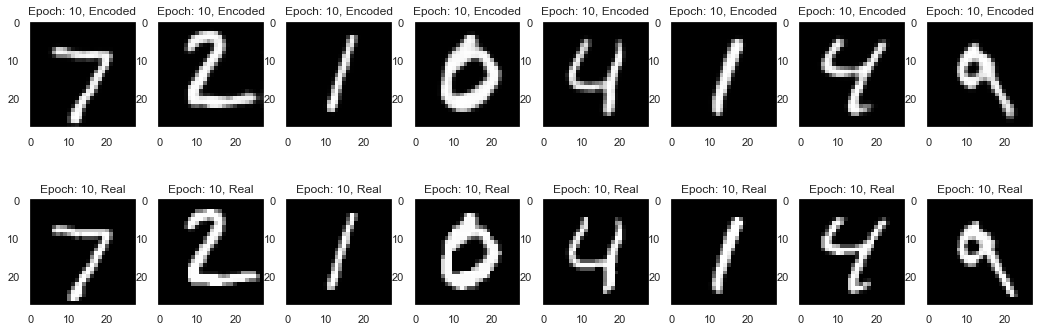

In [13]:
model_cnn.plot_outputs()